In [1]:
#https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])
model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v1 (KerasLayer)   (None, 1001)              6633209   
                                                                 
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


In [3]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')    
print(imagenet_labels.shape)

(1001,)


In [4]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}
img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}
print(img_name_tensors['Fireboat'].shape)

(224, 224, 3)


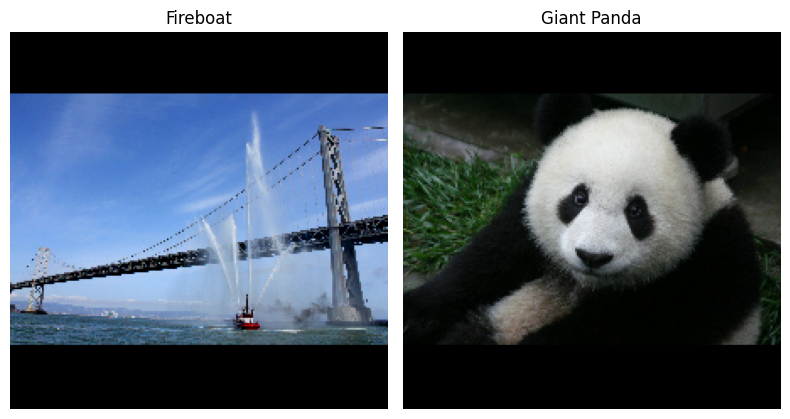

In [5]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 2, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

In [6]:
def top_k_predictions(img, k=3):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  print(top_idxs)
  return top_labels, top_probs[0]

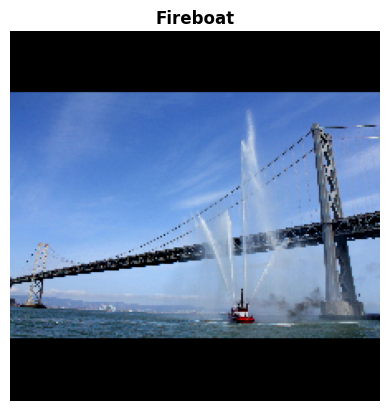

tf.Tensor([[555 719 840]], shape=(1, 3), dtype=int32)
fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%


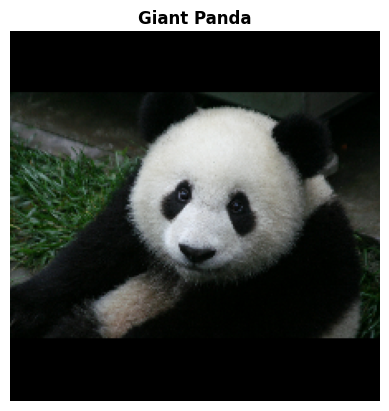

tf.Tensor([[389 851 369]], shape=(1, 3), dtype=int32)
giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%


In [7]:
for (name, img_tensor) in img_name_tensors.items():
  plt.imshow(img_tensor)
  plt.title(name, fontweight='bold')
  plt.axis('off')
  plt.show()

  pred_label, pred_prob = top_k_predictions(img_tensor)
  for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

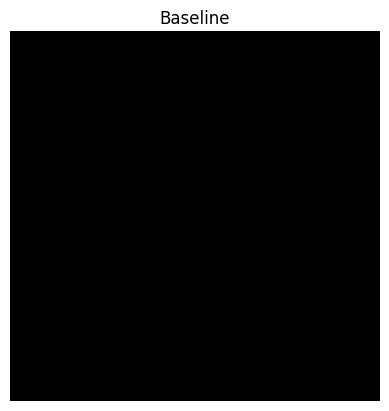

In [8]:
baseline = tf.zeros(shape=(224,224,3))
#baseline = tf.random.uniform(shape=(224,224,3), minval=0.0, maxval=1.0)
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [9]:
'''
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)
plt.plot(x,y)
plt.show()
'''

'\ndef f(x):\n  """A simplified model function."""\n  return tf.where(x < 0.8, x, 0.8)\n\ndef interpolated_path(x):\n  """A straight line path."""\n  return tf.zeros_like(x)\n\nx = tf.linspace(start=0.0, stop=1.0, num=6)\ny = f(x)\nplt.plot(x,y)\nplt.show()\n'

In [10]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  print(tf.newaxis)
  return images

In [11]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas=alphas)

None


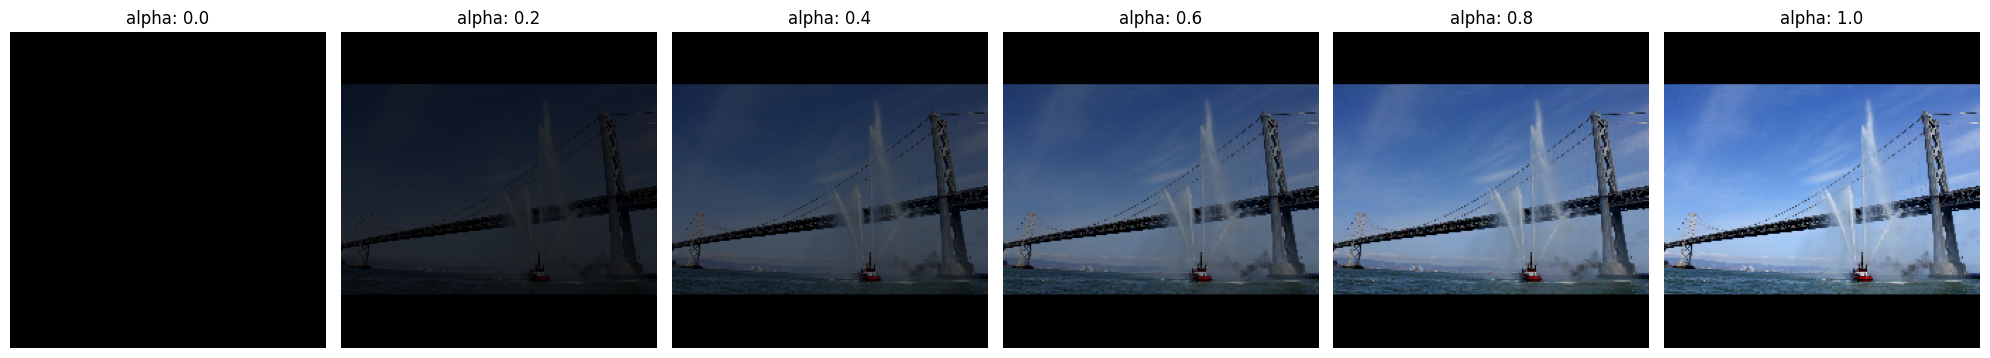

In [12]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

In [13]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  print(images.shape,logits.shape)   
  return tape.gradient(probs, images)

In [14]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=555) #555 is the index for the fire boat
print(path_gradients.shape)

(51, 224, 224, 3) (51, 1001)
(51, 224, 224, 3)


In [15]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]
pred_np = pred_proba.numpy()

(51, 1001) (51,) (51,) (51,) (50,)


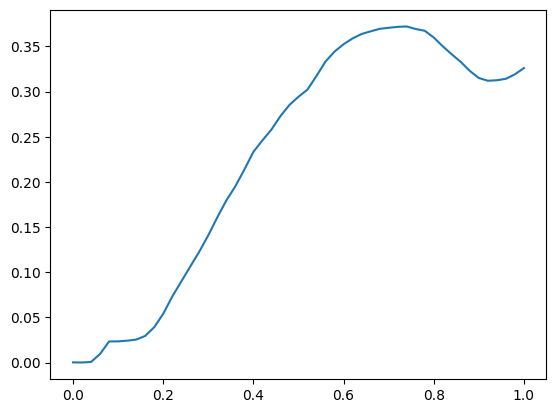

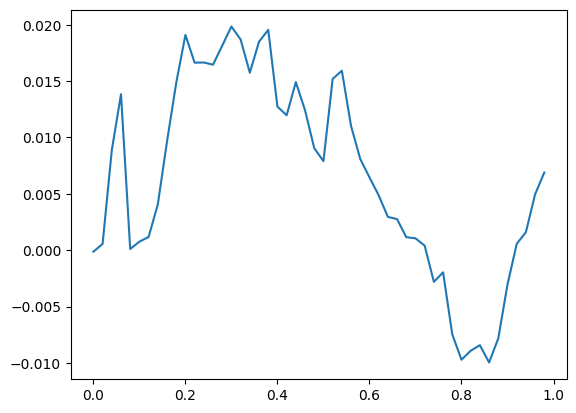

In [16]:
pred_diff = pred_np[1:]-pred_np[:-1]
print(pred.shape, pred_proba.shape, alphas.shape,pred_np.shape,pred_diff.shape)
plt.figure()
plt.plot(alphas,pred_proba)
plt.figure()
plt.plot(alphas[:-1],pred_diff)
plt.show()

In [17]:
aaa=np.array([0,1,2,3,4,5,6,7])
print(aaa[1:],aaa[:-1],aaa[1:5],aaa[1::3])

[1 2 3 4 5 6 7] [0 1 2 3 4 5 6] [1 2 3 4] [1 4 7]


(224, 224, 3)


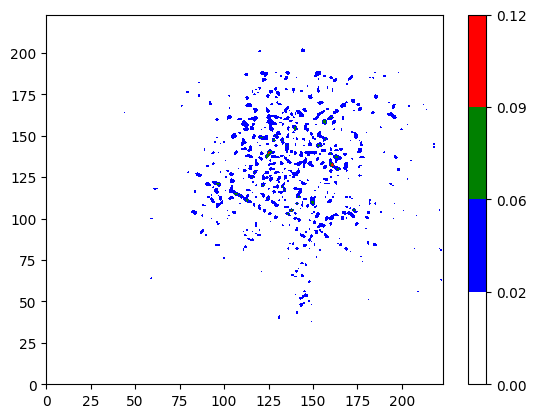

In [18]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients
ig = integral_approximation(
    gradients=path_gradients)
print(ig.shape)
levels = [0, 0.02, 0.06, 0.09, 0.12]
colors = ['w', 'b', 'g', 'r']
plt.contourf(ig[:,:,1],levels,colors=colors)
plt.colorbar()
plt.show()